In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [10]:
path = Path('/home/hpc/caph/mppi086h/vault/unbinned_analysis/simulations_of_weak_test_source_new/')

In [11]:
result = np.load(path/'result_0.02deg_24ebins.npy', allow_pickle=True).flat[0]
result

{'spatial_binsz': 0.02,
 'n_ebins': 24,
 'npred_sum': 1207.1288553455877,
 'fit_bins': 423044,
 'n_simulations': 100,
 'dTS_binned': array([3.27133166e+00, 1.39235321e+01, 1.61444148e+01, 2.13784015e+01,
        2.66193103e+01, 1.35717063e+01, 2.36321114e+01, 2.12563961e+01,
        2.15688823e+01, 3.13142489e+00, 2.22062768e+01, 8.28204649e+00,
        3.07040258e+00, 1.30571962e+01, 2.94199564e+01, 1.76222052e+01,
        6.09077203e+00, 1.18619120e+01, 8.92349261e+00, 1.85598570e+00,
        3.63574967e+00, 3.98479923e+00, 4.72841891e+00, 2.04817962e+01,
        4.11453811e+01, 3.26816006e+01, 6.57862799e+00, 1.60636476e+01,
        2.98252871e+01, 1.04928851e+01, 1.79437586e+01, 1.36248951e+01,
        3.74209972e+01, 9.16789478e+00, 1.82118345e+00, 1.06553496e+01,
        1.27128199e+01, 2.87909546e+01, 2.41309938e-02, 1.69691980e+01,
        2.13333886e+01, 1.58712084e+01, 5.56884727e+00, 1.13526591e+01,
        1.53656400e+01, 8.55032632e+00, 8.53817907e+00, 2.39186876e+01,
    

In [12]:
dTS_bin = result["dTS_binned"]
dTS_unb = result['dTS_unbinned']

par_bin = result['par_binned']
par_unb = result['par_unbin']

err_bin = result['err_binned']
err_unb = result['err_unbin']

print("avgTS binned:   ", np.mean(dTS_bin))
print("avgTS unbinned: ", np.mean(dTS_unb[~np.isnan(dTS_unb)]))

avgTS binned:    14.576265725904813
avgTS unbinned:  13.490064136317681


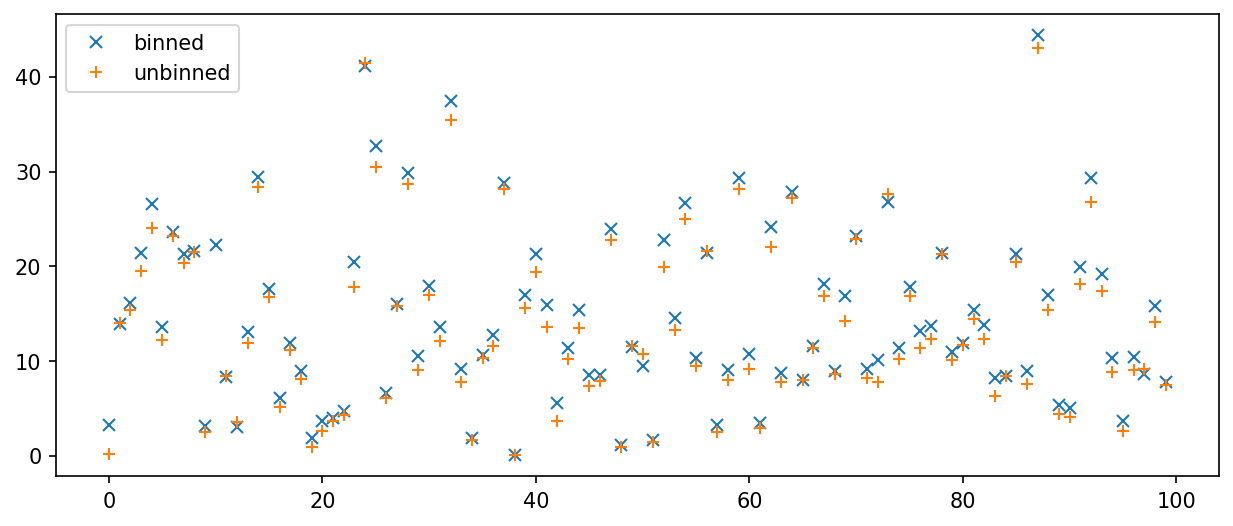

In [13]:
plt.figure(dpi=150, figsize=(10,4))
plt.plot(dTS_bin, 'x', label='binned')
plt.plot(dTS_unb, '+', label='unbinned')
plt.legend()

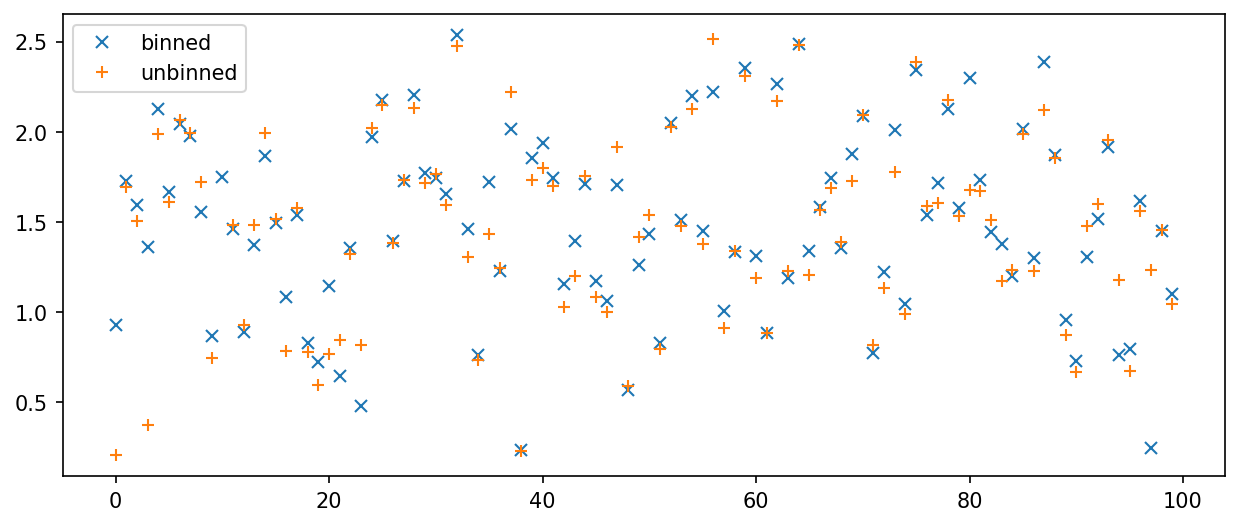

In [14]:
plt.figure(dpi=150, figsize=(10,4))
plt.plot(par_bin[:,1]/err_bin[:,1], 'x', label='binned')
plt.plot(par_unb[:,1]/err_unb[:,1], '+', label='unbinned')
plt.legend()

[]

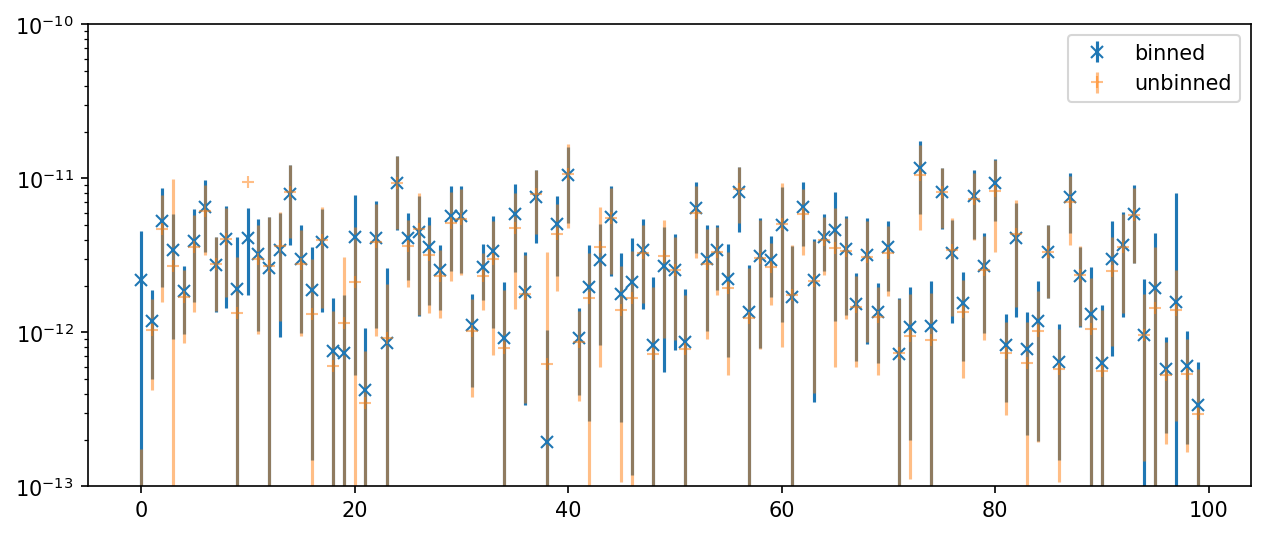

In [15]:
plt.figure(dpi=150, figsize=(10,4))
plt.errorbar(np.arange(par_bin.shape[0]), par_bin[:,1], fmt='x', yerr=err_bin[:,1], label='binned')
plt.errorbar(np.arange(par_bin.shape[0]), par_unb[:,1], fmt='+', yerr=err_unb[:,1], alpha=0.5, label='unbinned')
plt.legend()
plt.ylim(1e-13,1e-10)
plt.semilogy()

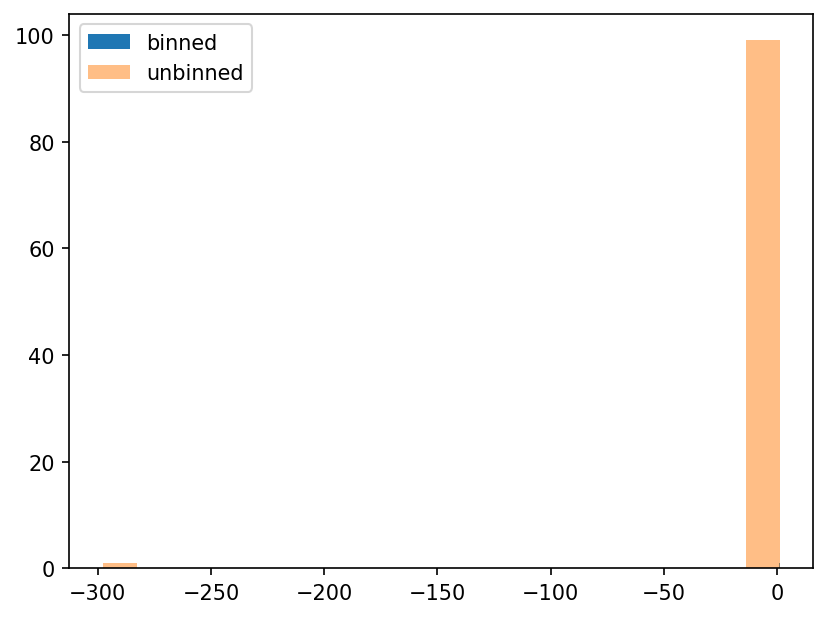

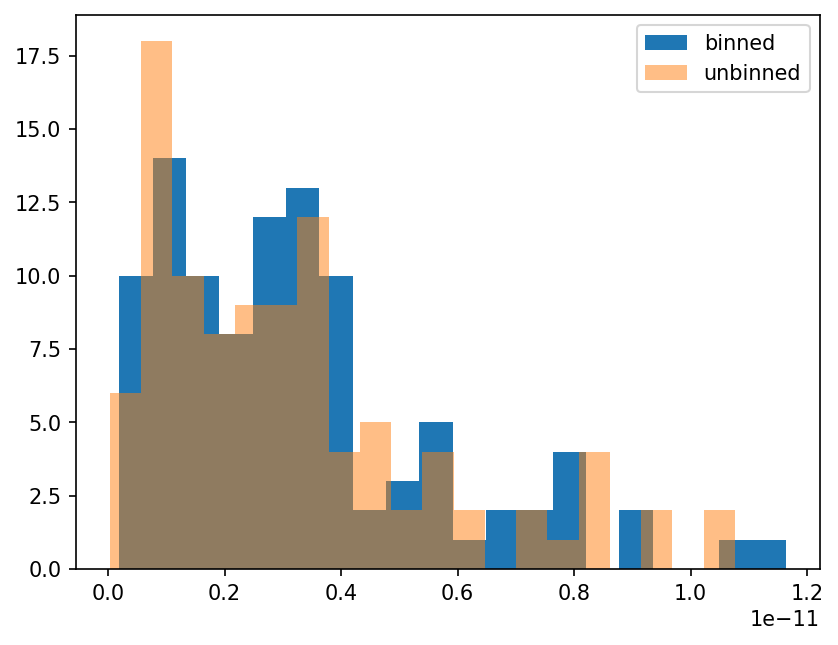

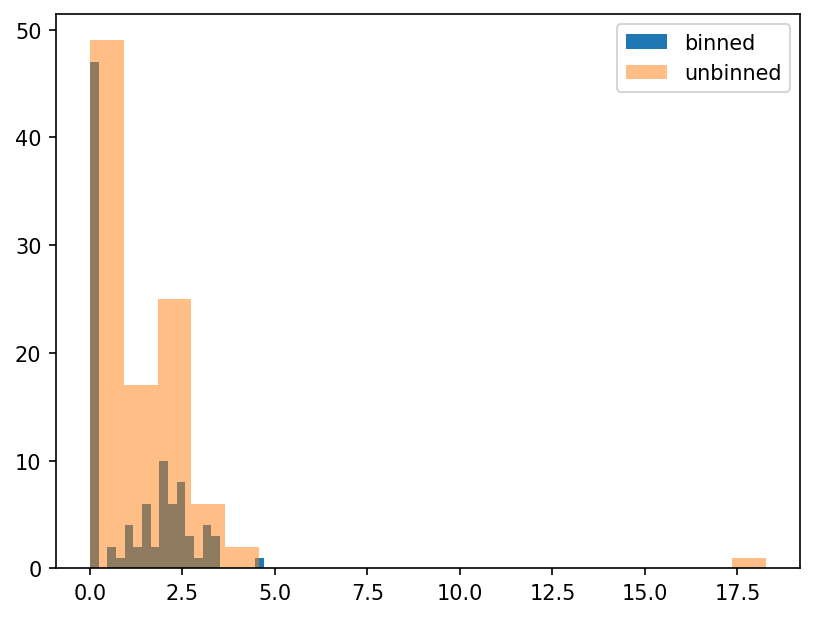

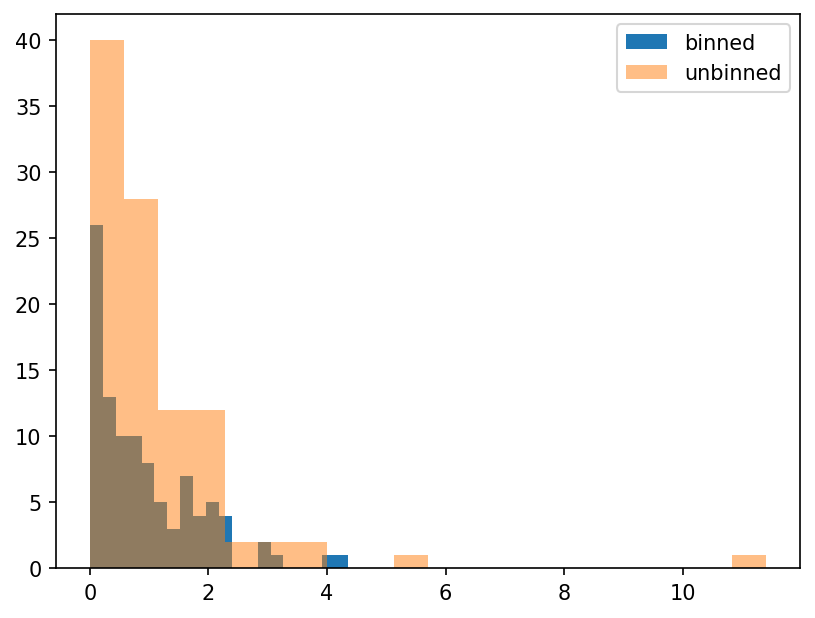

In [16]:
for i in range(par_bin.shape[-1]):
    fig = plt.figure(dpi=150)
    plt.hist(par_bin[:,i], 20, label="binned")
    plt.hist(par_unb[:,i], 20, label="unbinned", alpha=0.5)
    plt.legend()
    plt.show()

In [6]:
np.where(par_unb[:,2]>600)

(array([86, 87, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

# Investigate one MC

In [1]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler, Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.maps import MapAxis, WcsGeom, Map, MapAxes, MapCoord
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
#     Model,
#     Models,
    SkyModel,
#     PowerLawSpectralModel,
#     PowerLawNormSpectralModel,
    PointSpatialModel,
    LogParabolaSpectralModel,
#     GaussianSpatialModel,
#     TemplateSpatialModel,
#     ExpDecayTemporalModel,
#     LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
)
from gammapy.maps.geom import pix_tuple_to_idx
import warnings
from gammapy.utils.integrate import trapz_loglog
import sys
import os
os.chdir('/home/hpc/caph/mppi086h/gammapy-unbinned-analysis/EventDataset/')
print(os.getcwd())
sys.path.append('/home/hpc/caph/mppi086h/gammapy-unbinned-analysis/EventDataset/')
from EventDatasetMaker import EventDatasetMaker
from EventDataset import EventDataset

/home/hpc/caph/mppi086h/gammapy-unbinned-analysis/EventDataset


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
### Read inputs ###

# read in the command line arguments
spatial_binsz = 0.02 # in deg
n_ebins = 24
n=100  # number of simulations

### create a dataset
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos = obs1.pointing_radec
## choose energy binning
ebins = np.logspace(-1,2,n_ebins+1)
ebins_true = np.logspace(-1,2,49)

energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins_true, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=150, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=spatial_binsz,
    width=(3.5, 3.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
## make the dataset
maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg')
# providing the migra axis seems essential so that edisp is a EdispMap and no EdispKernelMap
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  

# the binned dataset
dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)
bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model

# the unbinned dataset
eds_maker = EventDatasetMaker(safe_mask_maker=maker_safe_mask, selection=None)
eds = eds_maker.run(reference, obs1)
eds.background = dataset.background.copy()
eds.mask_safe = dataset.mask_safe.copy()
bkg_model2 = FoVBackgroundModel(dataset_name=eds.name)
eds.models=bkg_model2

### set the model
model_gauss = SkyModel(
    spatial_model=PointSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab

model_gauss.spatial_model.parameters.freeze_all()
margin=0.1
model_gauss.spatial_model.lon_0.min = model_gauss.spatial_model.lon_0.value - margin
model_gauss.spatial_model.lon_0.max = model_gauss.spatial_model.lon_0.value + margin
model_gauss.spatial_model.lat_0.min = model_gauss.spatial_model.lat_0.value - margin
model_gauss.spatial_model.lat_0.max = model_gauss.spatial_model.lat_0.value + margin

model_gauss.spectral_model.amplitude.min = 0.
model_gauss.spectral_model.alpha.min = 0.
model_gauss.spectral_model.beta.min = 0.

dataset.models += model_gauss
eds.models += model_gauss.copy(name="crab_model")
eds.evaluators['crab_model'].spatialbs = spatial_binsz*u.deg

### calculate the avg events per bin
npred_sum = dataset.npred().data[dataset.mask_safe].sum()
fit_bins = dataset.mask_safe.data.sum()

In [4]:
### Compare analysis for n MC simulations

params=dataset.models.parameters.free_parameters.names # ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
par_input=[dataset.models.parameters[par].value for par in params]

In [8]:
par_binned=[]
err_binned=[]
par_unbin =[]
err_unbin =[]
dTS_binned = []
dTS_unbinned = []

ii = 86
### draw random revents
for i,par in enumerate(params):
    dataset.models.parameters.free_parameters[par].value = par_input[i]
    eds.models.parameters.free_parameters[par].value = par_input[i]
sampler = MapDatasetEventSampler(random_state=ii)
events = sampler.run(dataset, obs1)

### set up binned and unbinned datasets
counts = Map.from_geom(geom)
counts.fill_events(events)
dataset.counts=counts

eds.events = events
eds.evaluators['crab_model'].exposure = None # force update
eds._response_bkg_cached = None
del eds.evaluators['crab_model']._compute_npred

### fit both datasets
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run([dataset])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result2 = fit.run([eds])

### parameter comparison
par_binned.append([result.parameters[par].value for par in params])
err_binned.append([result.parameters[par].error for par in params])

par_unbin.append([result2.parameters[par].value for par in params])
err_unbin.append([result2.parameters[par].error for par in params])

### test of the source significance
ts_binned = result.total_stat
ts_unb = result2.total_stat

with dataset.models.parameters.restore_status():
    dataset.models.parameters['amplitude'].value = 0
    dataset.models['crab_model'].parameters.freeze_all()
    res=fit.optimize(dataset)
    ts_binned0 = res.total_stat
with eds.models.parameters.restore_status():
    eds.models.parameters['amplitude'].value = 0
    eds.models['crab_model'].parameters.freeze_all()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res2=fit.optimize([eds])
    ts_unb0 = res2.total_stat
dTS_binned.append(ts_binned0-ts_binned)
dTS_unbinned.append(ts_unb0-ts_unb)

result_dict = dict(
spatial_binsz       = spatial_binsz,
n_ebins             = n_ebins,
npred_sum           = npred_sum,
fit_bins            = fit_bins,
n_simulations       = n,
dTS_binned          = np.array(dTS_binned),
dTS_unbinned        = np.array(dTS_unbinned),
par_binned          = np.array(par_binned),
par_unbin           = np.array(par_unbin),
err_binned          = np.array(err_binned),
err_unbin           = np.array(err_unbin),
)

In [127]:
eds.response_signal()

(array([     0.        ,      0.        ,      0.        , ...,
           997.00164795, 321061.0625    ,  37992.49609375]),
 12.083098411560059)

In [128]:
ev = eds.evaluators['crab_model']

In [129]:
ev.irf_cube.shape

(152, 48, 10, 10)

In [130]:
np.any(np.isnan(ev.irf_cube))

False

In [131]:
np.any(np.isnan(ev.exposure))

False

In [132]:
np.any(np.isnan(ev.acceptance))

False

In [133]:
ev.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (10, 10, 48)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.7 deg, 22.0 deg
	width      : 0.2 deg x 0.2 deg
	wcs ref    : 83.6 deg, 21.5 deg

In [102]:
ev.__dict__

{'model': SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7f8547cde880>, spectral_model=<gammapy.modeling.models.spectral.LogParabolaSpectralModel object at 0x7f85468218e0>)temporal_model=None),
 'events': <gammapy.data.event_list.EventList at 0x7f854815aaf0>,
 'mask': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : ['lon', 'lat', 'energy']
 	shape : (175, 175, 24)
 	ndim  : 3
 	unit  : 
 	dtype : bool,
 'exposure': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : ['lon', 'lat', 'energy_true']
 	shape : (10, 10, 48)
 	ndim  : 3
 	unit  : m2 s
 	dtype : float32,
 'gti': None,
 'use_cache': True,
 '_init_position': None,
 'contributes': True,
 'psf_containment': None,
 'energy_axis': None,
 'spatialbs': <Quantity 0.02 deg>,
 'geom': WcsGeom
 
 	axes       : ['lon', 'lat', 'energy_true']
 	shape      : (10, 10, 48)
 	ndim       : 3
 	frame      : icrs
 	projection : CAR
 	center     : 83.6 deg, 22.0 deg
 	width      : 0.2 deg x 0.2 deg
 	wcs ref    : 83.6 deg, 21.5 

In [134]:
ev.model.position_lonlat

(3.221337116199552, -0.09933671901278918)

In [135]:
ev.contributes


True

In [136]:
del ev._compute_npred
ev.compute_npred()

[array([1.17291055e+04, 7.84226465e+03, 1.28280627e+03, 5.18141162e+03,
        5.06111183e+01, 3.57424831e+00, 2.30876636e+03, 1.87966589e+03,
        2.71893799e+03, 1.83138000e+02, 6.14609082e+03, 3.44373413e+02,
        1.45571265e+03, 7.78958936e+03, 1.73544189e+03, 1.17964492e+05,
        5.56214209e+03, 1.90604199e+03, 4.86169385e+03, 7.23938281e+03,
        3.33580005e+03, 4.03629907e+03, 2.11720098e+04, 2.90378750e+05,
        3.34129761e+02, 1.05840649e+03, 3.02771016e+04, 2.31033716e+03,
        3.48043481e+03, 1.09247278e+03, 6.26488965e+03, 9.88733105e+03,
        2.64477954e+03, 1.36627478e+03, 1.95249561e+03, 1.00909805e+02,
        1.63957832e+04, 1.52995959e+03, 1.90280823e+03, 3.69011261e+02,
        1.88196934e+04, 3.21984863e+03, 4.98273398e+04, 4.12146680e+03,
        3.70288184e+03, 3.08543976e+02, 1.56975594e+05, 1.50533906e+04,
        6.62314160e+03, 2.27006396e+03, 1.42600439e+03, 5.35158057e+03,
        2.01709531e+04, 6.24623926e+03, 4.18394684e+02, 2.926436

In [137]:
par_unbin

[[1.047428332174791,
  1.3262583655523158e-12,
  0.0017272939013882394,
  1.106584861999947,
  184.56902114707796,
  -5.6915747501097815]]

In [138]:
par_binned

[[1.046183647429106,
  1.5031576545179194e-12,
  0.00035938203664744224,
  1.1220313845393417,
  184.56953952917124,
  -5.690652734449133]]

In [139]:
par_input

[1.0, 3.5e-12, 1.8, 0.4, 184.557, -5.784]

In [140]:
dTS_binned, dTS_unbinned

([11.525746366340172], [10.258720666286536])

In [141]:
np.count_nonzero(events.table['MC_ID'])

17

In [142]:
np.count_nonzero(ev.events.table['MC_ID'])

14

In [143]:
events_signal = events.select_row_subset(events.table['MC_ID']==1)

In [144]:
events_signal.table

ENERGY_TRUE,RA_TRUE,DEC_TRUE,TIME,MC_ID,ENERGY,RA,DEC,DETX,DETY,EVENT_ID
TeV,deg,deg,s,,TeV,deg,deg,deg,deg,
float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
0.5534569627815457,83.64261029883579,22.024389885797053,123891385.89825122,1,1.2922771412501166,83.6063883195475,22.142068803897377,-0.024959374084617302,0.6276265118026321,3765
1.3898584262026537,83.63703950540986,22.022407782634186,123891879.64892504,1,1.3492056203973573,83.7759764010495,22.036003386288886,0.13222820630058932,0.5216193054632172,3766
3.4871940383166207,83.6299223522725,22.019723449796864,123891340.88009368,1,2.5795679657682307,83.64515595800245,21.833352359572636,0.010974751800058849,0.31890833037827,3767
0.8483092923530494,83.6394375221798,22.00866002459746,123891839.23475453,1,0.9526234108128095,83.73477889658443,21.92569507075879,0.09411031070532706,0.4112811805088789,3768
1.6023938825485258,83.63809054980925,22.01573469417073,123891873.99811016,1,1.2213465334681735,83.6559462871343,22.032652917726935,0.02096239196035207,0.5182099903290402,3769
2.2125527169174326,83.6304345275023,22.01909326367357,123892321.37162215,1,2.5387505905637426,83.57274842314084,22.1306818545507,-0.05612468472817081,0.6162482923643544,3770
0.941138686772484,83.62277270262183,22.023419741147535,123891554.8082735,1,1.231959232977329,83.38594853931527,21.78464356728035,-0.2297203495727276,0.2703809976781269,3771
1.8200336542904072,83.64172666549533,22.014262347864978,123892334.14038336,1,2.018998337349748,83.64145427112138,22.117755858566348,0.007523751273960347,0.6033116096648903,3772


In [145]:
events_inmask = events_signal.select_mask(dataset.mask_safe)

In [146]:
events_inmask.table

ENERGY_TRUE,RA_TRUE,DEC_TRUE,TIME,MC_ID,ENERGY,RA,DEC,DETX,DETY,EVENT_ID
TeV,deg,deg,s,,TeV,deg,deg,deg,deg,
float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
0.5534569627815457,83.64261029883579,22.024389885797053,123891385.89825122,1,1.2922771412501166,83.6063883195475,22.142068803897377,-0.024959374084617302,0.6276265118026321,3765
1.3898584262026537,83.63703950540986,22.022407782634186,123891879.64892504,1,1.3492056203973573,83.7759764010495,22.036003386288886,0.13222820630058932,0.5216193054632172,3766
3.4871940383166207,83.6299223522725,22.019723449796864,123891340.88009368,1,2.5795679657682307,83.64515595800245,21.833352359572636,0.010974751800058849,0.31890833037827,3767
1.6023938825485258,83.63809054980925,22.01573469417073,123891873.99811016,1,1.2213465334681735,83.6559462871343,22.032652917726935,0.02096239196035207,0.5182099903290402,3769
2.2125527169174326,83.6304345275023,22.01909326367357,123892321.37162215,1,2.5387505905637426,83.57274842314084,22.1306818545507,-0.05612468472817081,0.6162482923643544,3770
0.941138686772484,83.62277270262183,22.023419741147535,123891554.8082735,1,1.231959232977329,83.38594853931527,21.78464356728035,-0.2297203495727276,0.2703809976781269,3771
1.8200336542904072,83.64172666549533,22.014262347864978,123892334.14038336,1,2.018998337349748,83.64145427112138,22.117755858566348,0.007523751273960347,0.6033116096648903,3772
3.0453730680282387,83.64083093909466,22.021056065788063,123892382.08487411,1,2.277308679499692,83.67915426574977,22.085033910517563,0.04246101219650755,0.5705956927299345,3773


In [147]:
for eid in events_inmask.table['EVENT_ID']:
    print(eid in ev.events.table['EVENT_ID'])

True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [148]:
ev_evinmask = ev.events.select_row_subset(ev.event_mask)

In [149]:
ev_evinmask.table

ENERGY_TRUE,RA_TRUE,DEC_TRUE,TIME,MC_ID,ENERGY,RA,DEC,DETX,DETY,EVENT_ID
TeV,deg,deg,s,,TeV,deg,deg,deg,deg,
float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
1.5037020519201985,83.65471444316304,21.835841921400593,123891332.00256312,0,1.5037020519201985,83.65471444316304,21.835841921400593,0.01984739864890874,0.321398835065143,28
1.9880258773012585,83.48940972826881,21.94456203711914,123892478.40941764,0,1.9880258773012585,83.48940972826881,21.94456203711914,-0.13349949009005307,0.43017908375504477,40
1.1104085565983994,83.33935451730275,21.831596537959253,123891045.14137453,0,1.1104085565983994,83.33935451730275,21.831596537959253,-0.2728989389675687,0.317408847882654,42
2.0362226310789455,83.43128467983036,22.118041256215072,123892314.87513317,0,2.0362226310789455,83.43128467983036,22.118041256215072,-0.18719025366666195,0.6037178547258643,79
10.499814497933503,83.55680898349033,21.801490755926004,123891012.65549348,0,10.499814497933503,83.55680898349033,21.801490755926004,-0.07105192366565223,0.2870637125575541,160
16.689900894340294,83.87860772497558,21.758387280818173,123892195.45788082,0,16.689900894340294,83.87860772497558,21.758387280818173,0.22780186298829605,0.24412165372047961,189
1.6772300633460744,83.95872571513056,22.344481606800375,123891615.51014513,0,1.6772300633460744,83.95872571513056,22.344481606800375,0.3009916198345124,0.8303506075309356,216
1.5907075119875782,83.71561405658724,22.440748878706277,123891752.40185007,0,1.5907075119875782,83.71561405658724,22.440748878706277,0.07605993398008364,0.9263244630489673,317


In [150]:
for eid in events_inmask.table['EVENT_ID']:
    print(eid in ev_evinmask.table['EVENT_ID'])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
